# Blue Bikes Dataset Analysis 

In [1]:
#Function to support dependency 
import importlib
import subprocess

def import_or_install(package, name=None):
    try:
        # Try to import the package
        importlib.import_module(package)
    except ImportError:
        # If the import fails, install the package
        print(f"{name or package} not found. Installing...")
        subprocess.check_call(["pip", "install", package])
    
    print(f"Successfully imported {name or package}")

# List of required libraries
libraries = [
    ("pyspark", "PySpark"),
    ("matplotlib", "Matplotlib"),
    ("seaborn", "Seaborn"),
    ("numpy", "NumPy"),
    ("pandas", "Pandas"),
    ("scikit-learn", "scikit-learn")
]

# Import or install the required libraries
for package, name in libraries:
    import_or_install(package, name)

# Now you can use the imported libraries in your code


Successfully imported PySpark
Successfully imported Matplotlib
Successfully imported Seaborn
Successfully imported NumPy
Successfully imported Pandas
scikit-learn not found. Installing...
Successfully imported scikit-learn


In [39]:
# Import necessary PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import unix_timestamp, dayofmonth, hour, expr, col

# Import PySpark ML libraries for classification and regression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

# Import Matplotlib and Seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import NumPy for numerical computations
import numpy as np

# Import Pandas for working with data in a tabular format
import pandas as pd

# Import scikit-learn library for additional machine learning utilities
from sklearn.metrics import confusion_matrix


## Create Spark Session & Import Data

In [40]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 13 15:37:00 2023

@author: yjain
"""

from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("Citibikes") \
    .getOrCreate()



In [44]:

# Load the CSV file into a Spark DataFrame
combined_df = spark.read.csv("CBikes-Data-04-10.csv", header=True, inferSchema=True)



## EDA

In [45]:
combined_df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



In [46]:
combined_df.show(5)

+----------------+-------------+-------------------+-------------------+------------------+----------------+----------------+--------------+-----------------+------------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|start_station_name|start_station_id|end_station_name|end_station_id|        start_lat|         start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+------------------+----------------+----------------+--------------+-----------------+------------------+-----------------+------------------+-------------+
|38F943EA06A4E54F|electric_bike|2023-03-25 09:20:57|2023-03-25 09:32:10|   Jersey & 6th St|           JC027|    Glenwood Ave|         JC094|40.72528910781132|-74.04557168483734|40.72755146730012|-74.07106071710587|       member|
|C76EFC4C3B771E88|electric_bike|2023-03-15 07:55:41|2023-03-15 08:07:44|   Jersey & 

In [47]:
main_df = combined_df.select("member_casual","started_at","ended_at","start_lng","end_lng") #Selecting variables that we will use for analysis)

In [48]:
main_df.show(8)

+-------------+-------------------+-------------------+------------------+------------------+
|member_casual|         started_at|           ended_at|         start_lng|           end_lng|
+-------------+-------------------+-------------------+------------------+------------------+
|       member|2023-03-25 09:20:57|2023-03-25 09:32:10|-74.04557168483734|-74.07106071710587|
|       casual|2023-03-15 07:55:41|2023-03-15 08:07:44|-74.04557168483734|-74.07106071710587|
|       member|2023-03-20 08:50:11|2023-03-20 09:00:37|-74.04557168483734|-74.07106071710587|
|       casual|2023-03-02 10:17:07|2023-03-02 10:27:22|-74.04557168483734|-74.07106071710587|
|       member|2023-03-04 09:13:23|2023-03-04 09:25:30|-74.04557168483734|-74.07106071710587|
|       casual|2023-03-01 12:54:10|2023-03-01 13:05:27|-74.04557168483734|-74.07106071710587|
|       casual|2023-03-01 07:29:27|2023-03-01 07:39:18|     -74.045559406|-74.07106071710587|
|       casual|2023-03-28 13:00:47|2023-03-28 13:08:08|     

In [49]:
# Count the number of rows in the dataset
print("Total number of rows:", main_df.count())

Total number of rows: 649653


## Feature engineering

In [50]:
# Feature engineeing to get time of the day and ride duration
main_df = main_df.withColumn("trip_duration", (unix_timestamp("ended_at") - unix_timestamp("started_at")) / 60)  # Trip duration in minutes
main_df = main_df.withColumn("day_of_month", F.dayofmonth("started_at"))
main_df = main_df.withColumn("hour_of_day", F.hour("started_at"))


In [51]:
main_df.printSchema()

root
 |-- member_casual: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- trip_duration: double (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)



In [52]:
# Convert "member_casual" to a into labels
string_indexer = StringIndexer(inputCol="member_casual", outputCol="label")
model = string_indexer.fit(main_df)
main_df = model.transform(main_df)

In [53]:
main_df.show(6)

+-------------+-------------------+-------------------+------------------+------------------+------------------+------------+-----------+-----+
|member_casual|         started_at|           ended_at|         start_lng|           end_lng|     trip_duration|day_of_month|hour_of_day|label|
+-------------+-------------------+-------------------+------------------+------------------+------------------+------------+-----------+-----+
|       member|2023-03-25 09:20:57|2023-03-25 09:32:10|-74.04557168483734|-74.07106071710587|11.216666666666667|          25|          9|  0.0|
|       casual|2023-03-15 07:55:41|2023-03-15 08:07:44|-74.04557168483734|-74.07106071710587|             12.05|          15|          7|  1.0|
|       member|2023-03-20 08:50:11|2023-03-20 09:00:37|-74.04557168483734|-74.07106071710587|10.433333333333334|          20|          8|  0.0|
|       casual|2023-03-02 10:17:07|2023-03-02 10:27:22|-74.04557168483734|-74.07106071710587|             10.25|           2|         10

In [54]:

q1, q3 = main_df.approxQuantile('trip_duration', [0.25, 0.75], 0.05)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr
outliers = main_df.filter((main_df['trip_duration'] < lower_bound) | (main_df['trip_duration'] > upper_bound))


In [55]:
outliers.show()

+-------------+-------------------+-------------------+------------------+------------------+------------------+------------+-----------+-----+
|member_casual|         started_at|           ended_at|         start_lng|           end_lng|     trip_duration|day_of_month|hour_of_day|label|
+-------------+-------------------+-------------------+------------------+------------------+------------------+------------+-----------+-----+
|       casual|2023-03-26 10:32:55|2023-03-26 12:45:37|       -74.0335519| -74.0424120426178|             132.7|          26|         10|  1.0|
|       member|2023-03-30 20:37:11|2023-03-30 21:15:59|-74.02860336005688|-74.03030455112457|              38.8|          30|         20|  0.0|
|       casual|2023-03-16 18:26:09|2023-03-16 18:58:39|     -74.071233273|-74.03030455112457|              32.5|          16|         18|  1.0|
|       casual|2023-03-17 06:27:37|2023-03-17 07:17:26|     -74.036887527|-74.03030455112457| 49.81666666666667|          17|          6

We can see that some rides have started but not ended, which is why their trip duration is so high , we are going to remove these as they can hinder with out data 

In [56]:

outlier_df = main_df.filter(
    (col("trip_duration") > 300) & (~col("end_station_id").isNull())
)



In [57]:
outlier_df.show()

+-------------+-------------------+-------------------+------------------+------------------+------------------+------------+-----------+-----+
|member_casual|         started_at|           ended_at|         start_lng|           end_lng|     trip_duration|day_of_month|hour_of_day|label|
+-------------+-------------------+-------------------+------------------+------------------+------------------+------------+-----------+-----+
|       member|2023-03-20 23:49:00|2023-03-21 07:18:32|-74.07126188278198|-74.03030455112457|449.53333333333336|          20|         23|  0.0|
|       casual|2023-03-20 16:30:26|2023-03-21 13:31:34|-74.02698867022991|       -74.0575736|1261.1333333333334|          20|         16|  1.0|
|       casual|2023-03-28 18:51:10|2023-03-29 10:37:27|-74.07126188278198|       -74.0641943| 946.2833333333333|          28|         18|  1.0|
|       member|2023-03-11 12:00:31|2023-03-11 17:53:48|-74.06443700194359|-74.04288411140442|353.28333333333336|          11|         12

In [58]:
# Filter out rows with trip_duration greater than 300 and end_station_id equals 'NULL'
main_df = main_df.filter((col("trip_duration") <= 300) & (col("end_station_id") != 'NULL'))

# Show the filtered DataFrame
main_df.show()


+-------------+-------------------+-------------------+------------------+------------------+------------------+------------+-----------+-----+
|member_casual|         started_at|           ended_at|         start_lng|           end_lng|     trip_duration|day_of_month|hour_of_day|label|
+-------------+-------------------+-------------------+------------------+------------------+------------------+------------+-----------+-----+
|       member|2023-03-25 09:20:57|2023-03-25 09:32:10|-74.04557168483734|-74.07106071710587|11.216666666666667|          25|          9|  0.0|
|       casual|2023-03-15 07:55:41|2023-03-15 08:07:44|-74.04557168483734|-74.07106071710587|             12.05|          15|          7|  1.0|
|       member|2023-03-20 08:50:11|2023-03-20 09:00:37|-74.04557168483734|-74.07106071710587|10.433333333333334|          20|          8|  0.0|
|       casual|2023-03-02 10:17:07|2023-03-02 10:27:22|-74.04557168483734|-74.07106071710587|             10.25|           2|         10

In [59]:
# Check for duplicate rows and remove them if necess
main_df.dropDuplicates()

DataFrame[member_casual: string, started_at: timestamp, ended_at: timestamp, start_lng: double, end_lng: double, trip_duration: double, day_of_month: int, hour_of_day: int, label: double]

In [60]:
# Count the number of rows in the dataset
print("Total number of rows:", main_df.count())

Total number of rows: 646709


NO DUPLICATES FOUND

## Casual VS Member Rider Type Analysis

In [61]:
combined_df.createOrReplaceTempView("blue_bikes_data")

# Business Question 1: How many total trips are there in the dataset?
total_trips_query = """
SELECT COUNT(*) AS total_trips
FROM blue_bikes_data
"""
total_trips = spark.sql(total_trips_query)
total_trips.show()

top_stations_query = """
SELECT start_station_name, COUNT(*) AS trip_count
FROM blue_bikes_data
GROUP BY start_station_name
ORDER BY trip_count DESC
LIMIT 10
"""
top_stations = spark.sql(top_stations_query)
top_stations.show()



+-----------+
|total_trips|
+-----------+
|     649653|
+-----------+

+--------------------+----------+
|  start_station_name|trip_count|
+--------------------+----------+
|       Grove St PATH|     30886|
|Hoboken Terminal ...|     26962|
|South Waterfront ...|     22655|
|Hoboken Terminal ...|     17385|
|City Hall - Washi...|     16134|
|        Newport PATH|     15565|
|        Newport Pkwy|     14179|
|       Hamilton Park|     14115|
|12 St & Sinatra Dr N|     13845|
|Bergen Ave & Sip Ave|     12846|
+--------------------+----------+



In [62]:
# Count the total number of rows in the dataset
total_count = main_df.count()

# Count the number of members and casual riders
member_count = main_df.filter(main_df['label'] == 1).count()
casual_count = main_df.filter(main_df['label'] == 0).count()

# Calculate the percentage of members and casual riders
member_percentage = (member_count / total_count) * 100
casual_percentage = (casual_count / total_count) * 100

print(f"Percentage of members: {member_percentage:.2f}%")
print(f"Percentage of casual riders: {casual_percentage:.2f}%")


Percentage of members: 27.88%
Percentage of casual riders: 72.12%


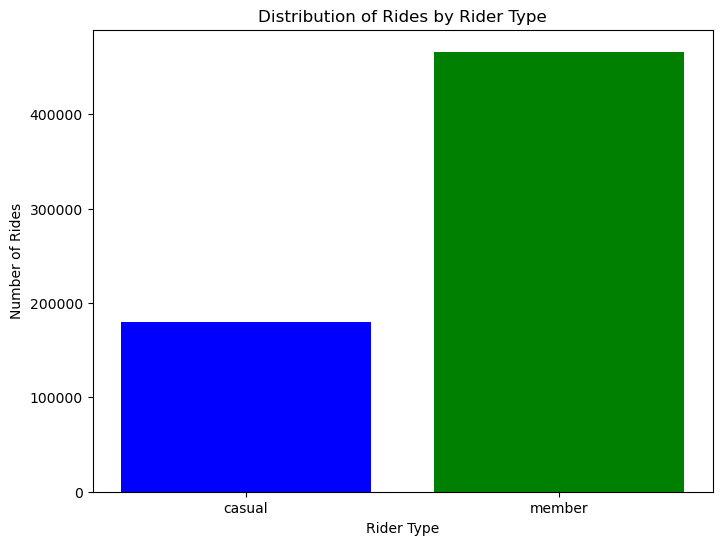

In [63]:
# Group the data by the 'member_casual' column and count the number of rides for each group.
ride_count = main_df.groupBy("member_casual").count()

# Convert the result to a Pandas DataFrame for easier plotting.
ride_count_df = ride_count.toPandas()

# Create a bar plot to visualize the distribution of rides.
plt.figure(figsize=(8, 6))
plt.bar(ride_count_df['member_casual'], ride_count_df['count'], color=['blue', 'green'])
plt.xlabel('Rider Type')
plt.ylabel('Number of Rides')
plt.title('Distribution of Rides by Rider Type')
plt.show()

##### We can see that there is class imbalance in member_casual column 

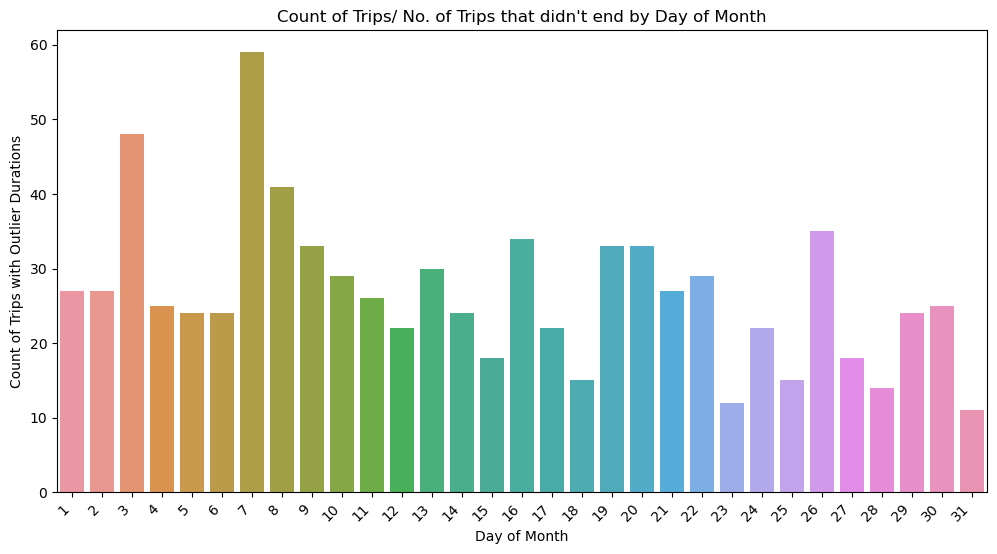

In [64]:


# Group and count the number of trips with outlier durations for each day of the month
outlier_counts_by_month = outlier_df.groupBy("day_of_month").count().orderBy("day_of_month")

# Convert the result to a Pandas DataFrame for visualization
outlier_counts_pd = outlier_counts_by_month.toPandas()

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot
ax = sns.barplot(x="day_of_month", y="count", data=outlier_counts_pd)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.xlabel("Day of Month")
plt.ylabel("Count of Trips with Outlier Durations")
plt.title("Count of Trips/ No. of Trips that didn't end by Day of Month")
plt.show()


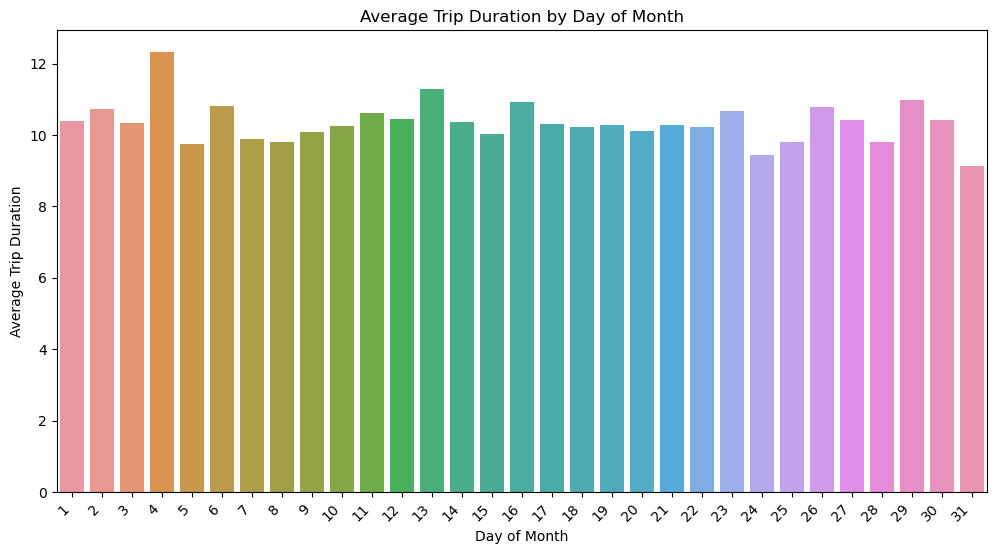

In [65]:
# Display results using Seaborn with improved dimensions
plt.figure(figsize=(12, 6))  # Set the figure size

day_avg_duration = main_df.select("day_of_month", "trip_duration").groupby("day_of_month").avg("trip_duration").toPandas()
ax = sns.barplot(x="day_of_month", y="avg(trip_duration)", data=day_avg_duration)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.xlabel("Day of Month")
plt.ylabel("Average Trip Duration")
plt.title("Average Trip Duration by Day of Month")
plt.show()


Area Under ROC (AUC): 0.6728548985186754
+----------------+-----+----+
|label_prediction|  0.0| 1.0|
+----------------+-----+----+
|             1.0|31660|4120|
|             0.0|90929|2514|
+----------------+-----+----+



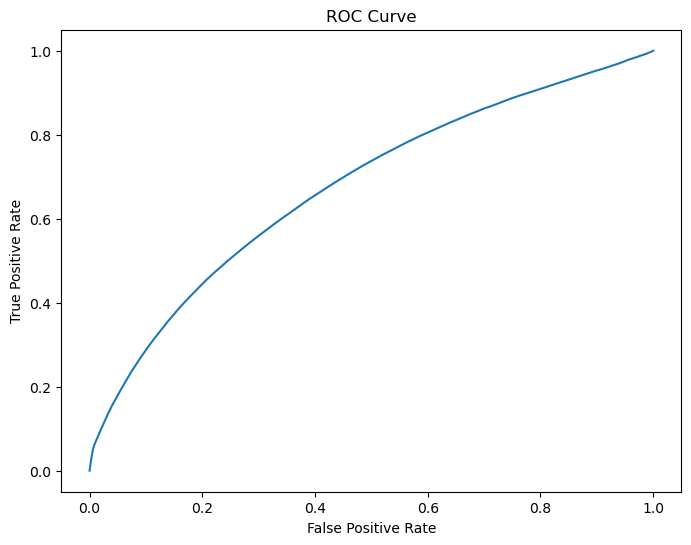

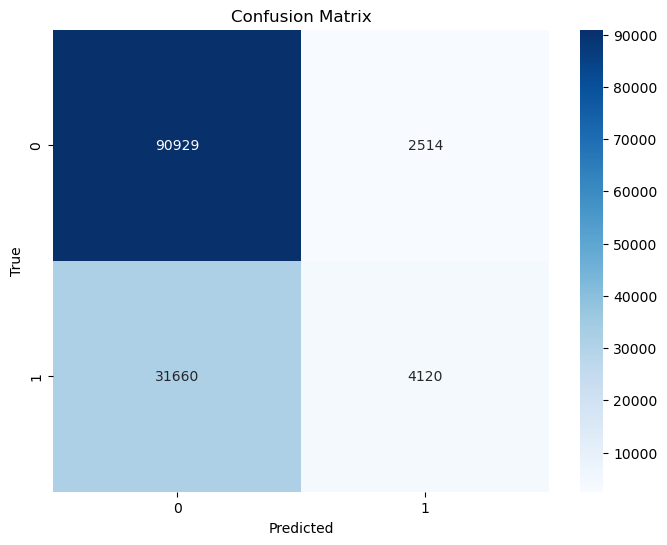

In [66]:


# Define the feature columns and target column
feature_columns = ["start_lng", "end_lng", "trip_duration", "day_of_month", "hour_of_day"]
target_column = "label"

# Create a VectorAssembler to combine the features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the main_df DataFrame to include the "features" column
main_df = assembler.transform(main_df)

# Split the data into training and test sets (e.g., 80% for training, 20% for testing)
train_data, test_data = main_df.randomSplit([0.8, 0.2], seed=123)


# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol=target_column)

# Fit the model to the training data
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol=target_column, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

# Print the Area Under the ROC Curve (AUC)
print(f"Area Under ROC (AUC): {auc}")

# Visualize the results
actual = np.array(predictions.select(target_column).collect())
predicted = np.array(predictions.select("prediction").collect())

# Confusion matrix
conf_matrix = predictions.crosstab("label", "prediction")
conf_matrix.show()

# Receiver Operating Characteristic (ROC) curve
roc = model.summary.roc.toPandas()
plt.figure(figsize=(8, 6))
plt.plot(roc['FPR'], roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate the confusion matrix
y_true = np.array(predictions.select(target_column).collect())
y_pred = np.array(predictions.select("prediction").collect())

# Visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = [0, 1]  # Your class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Random Forest Classifier Accuracy: 0.7411296750578458
Confusion Matrix:
[[91076  2367]
 [31085  4695]]


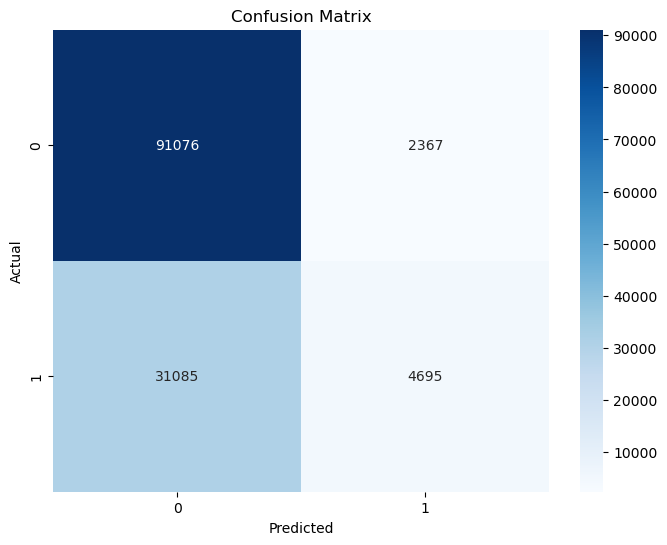

Classification Report:
              precision    recall  f1-score   support

      casual       0.75      0.97      0.84     93443
      member       0.66      0.13      0.22     35780

    accuracy                           0.74    129223
   macro avg       0.71      0.55      0.53    129223
weighted avg       0.72      0.74      0.67    129223



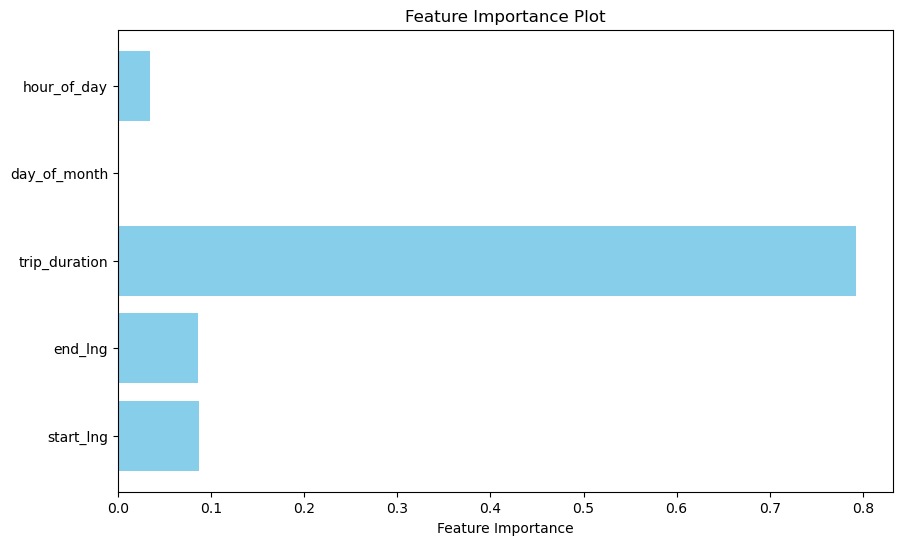

In [67]:
# Apply a Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol=target_column, numTrees=100, maxDepth=5)
model = rf_classifier.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Collect the predictions and ground truth as Pandas DataFrames
predictions_df = predictions.select("prediction").toPandas()
true_labels_df = predictions.select(target_column).toPandas()

# Print the accuracy of the classifier
print(f"Random Forest Classifier Accuracy: {accuracy}")

# Calculate the confusion matrix
confusion_matrix_df = confusion_matrix(true_labels_df, predictions_df)
print("Confusion Matrix:")
print(confusion_matrix_df)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
from sklearn.metrics import classification_report
# Classification Report
class_names = ["casual", "member"]
report = classification_report(true_labels_df, predictions_df, target_names=class_names)
print("Classification Report:")
print(report)

# Feature Importance
feature_importance = model.featureImportances
feature_names = feature_columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()


In [68]:
spark.stop()